Latent Variable Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import statsmodels.api as sm

rng = np.random.default_rng()

import pymc as pm
import arviz as az
# import pymc_experimental as pmx

In [2]:
x_min, x_max = -5, 5

def mu_true(x):
    return 1.0/(1.0+np.exp(-x))

def sigma_true(x):
    return 0.5+0.5/(1.0+x**2)

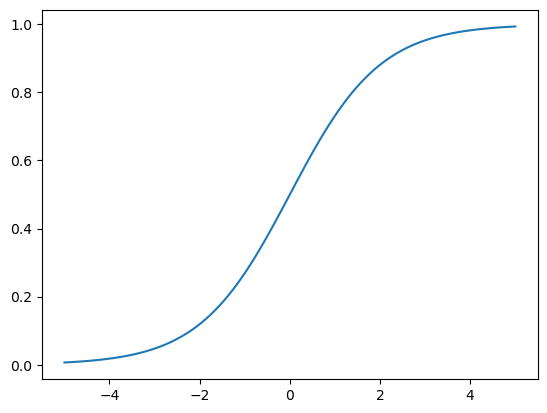

In [3]:
x_vals = np.linspace(x_min,x_max,100)
plt.plot(x_vals,mu_true(x_vals))

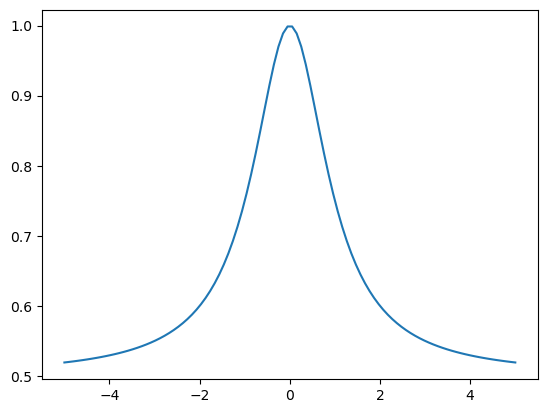

In [4]:
plt.plot(x_vals,sigma_true(x_vals))

In [5]:
x_sample = np.linspace(x_min,x_max,20)

In [6]:
n_samples = 10

y_obs = []

for x in x_sample:
    mu = mu_true(x)
    sigma = sigma_true(x)

    y = rng.normal(mu, sigma, size=n_samples)
    y_obs.append(y)

x_obs = np.tile(x_sample,(n_samples,1)).T
y_obs = np.array(y_obs)


y_obs_mean = y_obs.mean()
y_obs_std = y_obs.std()
z_obs = (y_obs - y_obs_mean)/y_obs_std

In [7]:
y_mean_est = y_obs.mean(axis=1)
y_std_est = y_obs.std(axis=1)
y_mean_se = y_std_est / np.sqrt(n_samples)
alpha = 0.05
z_alpha = sp.stats.t.ppf(1-alpha/2, n_samples-1)

<ErrorbarContainer object of 3 artists>

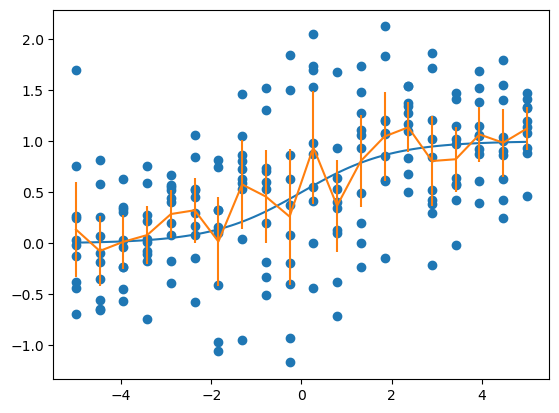

In [8]:
plt.scatter(x_obs,y_obs)
plt.plot(x_vals, mu_true(x_vals))
plt.errorbar(x_sample,y_mean_est,yerr = z_alpha * y_mean_se)

In [9]:
X = x_obs.ravel().reshape(-1,1)

In [31]:
with pm.Model() as model:
    # l = 2.0

    # ls_loc = pm.InverseGamma("ls_loc", mu = 2.0, sigma = 2.0)
    ls_loc = pm.Gamma("ls_loc", mu = 2.0, sigma = 2.0)
    ls_scale = pm.InverseGamma("ls_scale", mu = 2.0, sigma = 2.0)
    s2_loc = pm.Gamma("s2_loc", alpha = 2, beta = 1)
    s2_scale = pm.Gamma("s2_scale", alpha = 2, beta = 1)
    # cov_loc = s2_loc**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_loc) + pm.gp.cov.WhiteNoise(sigma = 1e-6)
    # cov_scale = s2_scale**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_scale) + pm.gp.cov.WhiteNoise(sigma = 1e-6)
    cov_loc =  s2_loc**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_loc) 
    cov_scale = s2_scale**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_scale) 
# 

    # cov_loc =  η**2 * pm.gp.cov.ExpQuad(1, ls=5.0) + pm.gp.cov.WhiteNoise(sigma=1e-6)
    # cov_scale = pm.gp.cov.ExpQuad(1, ls=5.0)
    # cov_loc = pm.gp.cov.Exponential(1, ls=5.0)
    # cov_scale = pm.gp.cov.Exponential(1, ls=5.0)

    gp_loc = pm.gp.Latent(cov_func = cov_loc)
    gp_log_scale = pm.gp.Latent(cov_func = cov_scale)

    mu = gp_loc.prior('mu', X = X)
    log_sigma = gp_log_scale.prior('log_sigma', X = X)

    z = pm.Normal('z', mu = mu, sigma = pm.math.exp(log_sigma), observed = z_obs.ravel())
    # y = z * y_obs_std + y_obs_mean

    vi_approx = pm.fit()
    trace = vi_approx.sample(1000)
    # trace = pm.sample(1000, return_inferencedata = True, chains=2, cores=2)

Finished [100%]: Average Loss = 293.98


array([<AxesSubplot: title={'center': 'ls_loc'}>,
       <AxesSubplot: title={'center': 's2_loc'}>], dtype=object)

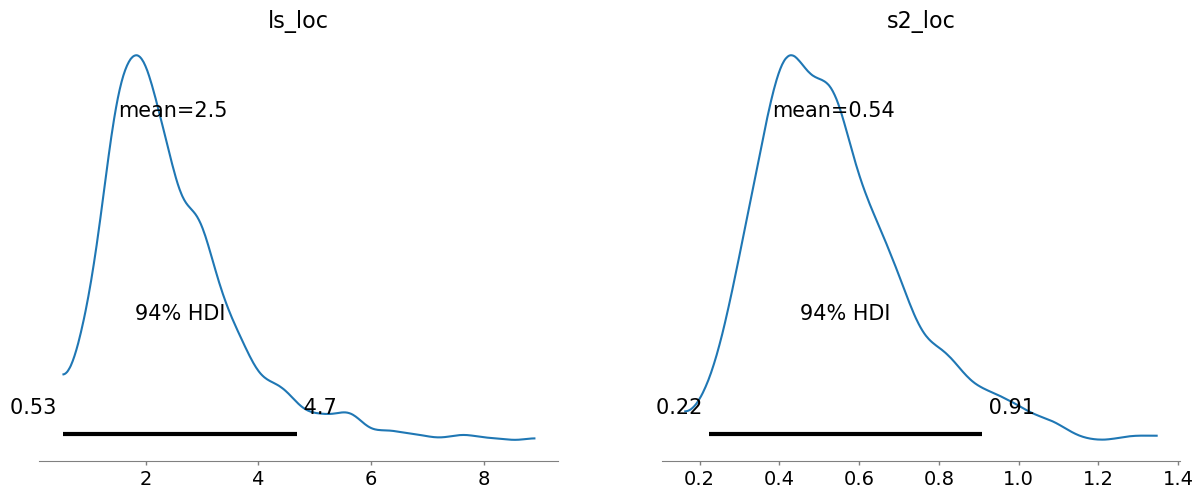

In [32]:
az.plot_posterior(trace, var_names = ["ls_loc",  "s2_loc"])

In [25]:
X.shape, Xpred.shape

((200, 1), (100, 1))

In [29]:
Xpred = x_vals.reshape(-1,1)

In [33]:
with model:
    mu_pred = gp_loc.conditional("mu_pred3", Xnew=Xpred)
    log_sigma_pred = gp_log_scale.conditional("log_sigma_pred3", Xnew=Xpred)
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["mu_pred3", "log_sigma_pred3"])

Sampling: [log_sigma_pred3, mu_pred3]


ValueError: The input matrix must be symmetric positive semidefinite.
Apply node that caused the error: multivariate_normal_rv{1, (1, 2), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FB00B4E0C80>), [], 11, BroadcastTo.0, Gemm{inplace}.0)
Toposort index: 61
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(0,)), TensorType(int64, shape=()), TensorType(float64, shape=(100,)), TensorType(float64, shape=(100, 100))]
Inputs shapes: ['No shapes', (0,), (), (100,), (100, 100)]
Inputs strides: ['No strides', (0,), (), (8,), (800, 8)]
Inputs values: [Generator(PCG64) at 0x7FB00B4E0C80, array([], dtype=int64), array(11), 'not shown', 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

array([[<AxesSubplot: title={'center': 'mu_rotated_'}>,
        <AxesSubplot: title={'center': 'mu_rotated_'}>],
       [<AxesSubplot: title={'center': 'log_sigma_rotated_'}>,
        <AxesSubplot: title={'center': 'log_sigma_rotated_'}>],
       [<AxesSubplot: title={'center': 'ls_loc'}>,
        <AxesSubplot: title={'center': 'ls_loc'}>],
       [<AxesSubplot: title={'center': 's2_loc'}>,
        <AxesSubplot: title={'center': 's2_loc'}>],
       [<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>],
       [<AxesSubplot: title={'center': 'log_sigma'}>,
        <AxesSubplot: title={'center': 'log_sigma'}>]], dtype=object)

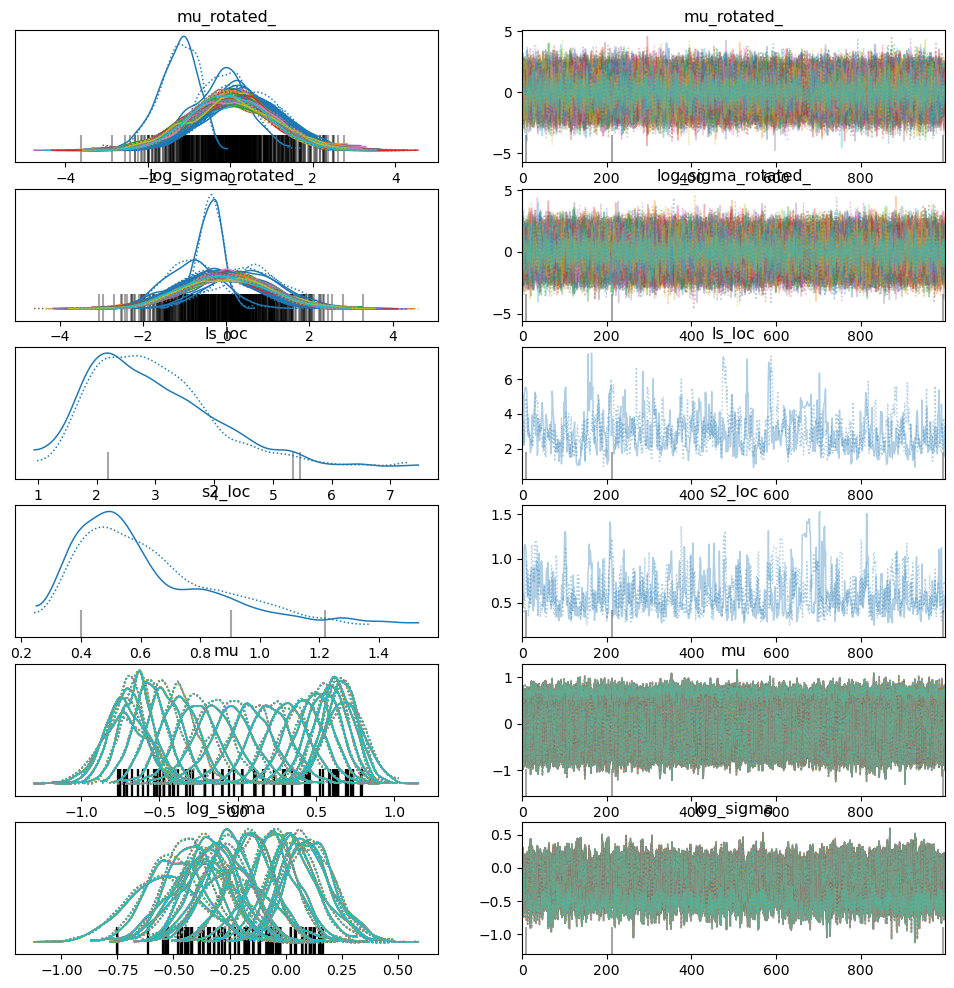

In [16]:
# az.plot_trace(trace)

In [ ]:
y_mean = y_obs.mean(axis=1)
y_sigma = np.std(y_obs,axis=1)

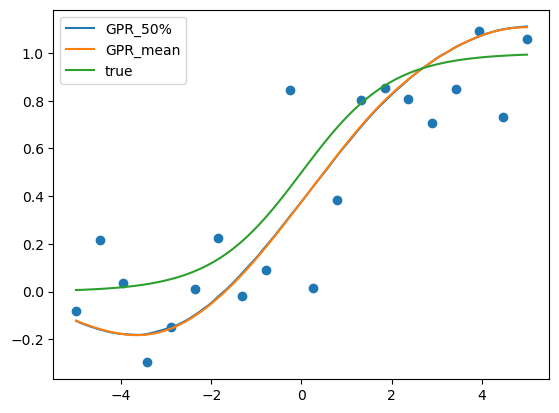

In [ ]:
plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred2'].median(axis=(0,1))+y_obs_mean,label='GPR_50%')
plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred2'].mean(axis=(0,1))+y_obs_mean,label='GPR_mean')
plt.plot(x_vals, mu_true(x_vals),label='true')
plt.scatter(x_sample,y_mean)
plt.legend()

In [ ]:
np.percentile

In [ ]:
alpha = 0.05
latent_mu_median = posterior_pred.posterior_predictive['mu_pred2'].mean(axis=(0,1))+y_obs_mean
latent_mu_L = np.quantile(posterior_pred.posterior_predictive['mu_pred2'],alpha/2, axis=(0,1))+y_obs_mean
latent_mu_U = np.quantile(posterior_pred.posterior_predictive['mu_pred2'], 1-alpha/2, axis=(0,1))+y_obs_mean

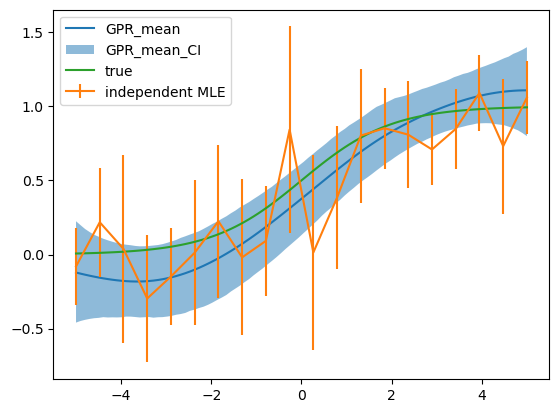

In [ ]:
# plt.scatter(x_obs,y_obs)

plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred2'].mean(axis=(0,1))+y_obs_mean,label='GPR_mean')
plt.fill_between(x_vals,latent_mu_L,latent_mu_U,alpha=0.5,label='GPR_mean_CI')
plt.errorbar(x_sample,y_mean_est,yerr = z_alpha * y_mean_se,label='independent MLE')
plt.plot(x_vals, mu_true(x_vals),label='true')
plt.legend()

Smoother results with more accuracy (except for the edges)


In [ ]:
sigma_pred = np.exp(posterior_pred.posterior_predictive['log_sigma_pred2'])*y_obs_std

latent_sigma_median = np.quantile(sigma_pred,0.5, axis=(0,1))
latent_sigma_L = np.quantile(sigma_pred, alpha/2, axis=(0,1))
latent_sigma_U = np.quantile(sigma_pred, 1-alpha/2, axis=(0,1))

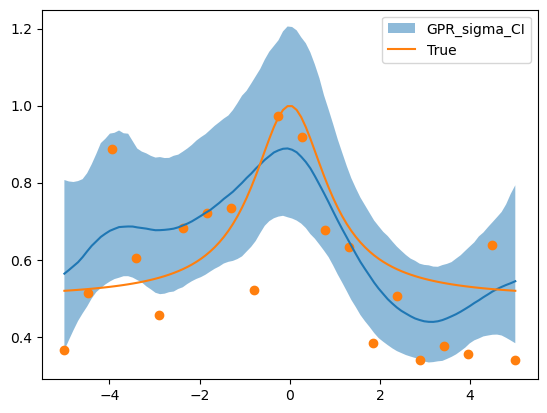

In [ ]:



plt.plot(x_vals,latent_sigma_median)
plt.fill_between(x_vals,latent_sigma_L,latent_sigma_U,alpha=0.5,label='GPR_sigma_CI')

plt.scatter(x_sample,y_sigma)
plt.plot(x_vals, sigma_true(x_vals),label='True')
plt.legend()